In [69]:
# ！pip install functorch
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.autograd import Variable
import pandas as pd
import scipy
from scipy import stats
import numpy as np
from os import path
import torchvision

In [70]:
device = "cuda" if torch.cuda.is_available() else "cpu"
# print(torch.cuda.get_device_name())
print(f"Using {device} device")

Using cpu device


In [71]:
MA_DAYS = 25
trading_days_in_year = 252

# Import raw data from yahoo finance

In [72]:
from google.colab import drive
drive.mount('/content/drive')
data_files_path_prefix = "/content/drive/MyDrive"
data_files_path = "ML-Portfolio-Data"
data_files_path = path.join(data_files_path_prefix, data_files_path)

high_risk_file = 'SPY.csv'
low_risk_file = 'IEF.csv'
high_risk = pd.read_csv(path.join(data_files_path, high_risk_file))
low_risk = pd.read_csv(path.join(data_files_path, low_risk_file))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [73]:
# Read files from the same directory
#high_risk = pd.read_csv('SPY.csv')
#low_risk = pd.read_csv('O9P.SI.csv')

In [74]:
# high_risk = high_risk[:1008]
# low_risk = low_risk[:1008]
print(high_risk.shape)
print(low_risk.shape)

(5147, 7)
(5147, 7)


In [75]:
high_risk.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2002-07-30,89.320000,91.400002,88.720001,90.940002,61.380939,47532200
1,2002-07-31,90.489998,91.550003,89.250000,91.160004,61.529453,44669900
2,2002-08-01,90.879997,91.349998,88.330002,88.779999,59.923054,66571900
3,2002-08-02,88.500000,88.910004,85.620003,86.790001,58.579895,51772900
4,2002-08-05,86.489998,86.930000,83.550003,83.769997,56.541496,47191300


In [76]:
low_risk.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2002-07-30,81.940002,82.120003,81.699997,81.769997,45.672558,41300
1,2002-07-31,82.050003,82.580002,82.050003,82.519997,46.091442,32600
2,2002-08-01,82.540001,82.900002,82.519997,82.860001,46.281376,71400
3,2002-08-02,83.019997,83.699997,82.900002,83.500000,46.638828,120300
4,2002-08-05,83.680000,83.919998,83.529999,83.919998,46.873459,159300


# ML Portfolio

In [77]:
from sklearn.model_selection import KFold
from torch.utils.data import Dataset, DataLoader,TensorDataset,random_split,SubsetRandomSampler, ConcatDataset

## Enrich data

### Calculate daily returns

In [78]:
def add_daily_return(market_data):
    market_data["Daily Return"]  = market_data['Close'] - market_data['Open']

add_daily_return(high_risk)
add_daily_return(low_risk)

### Calculate moving average (MA) of daily returns

In [79]:
def add_moving_average(market_data, ma_days):
    temp_vars = []

    # df = market_data
    for i in range(0,ma_days):
        temp_var = "M_{0}".format(i)
        market_data[temp_var] = market_data["Daily Return"].shift(i)
        temp_vars.append(temp_var)

    market_data["MA"] = market_data[temp_vars].mean(axis=1)

    for i in range(0,ma_days):
        temp_var = "M_{0}".format(i)
        market_data.drop(temp_var, axis = 1, inplace = True)

add_moving_average(high_risk, MA_DAYS)
add_moving_average(low_risk, MA_DAYS)


In [80]:
high_risk.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Daily Return,MA
5142,2022-12-30,380.640015,382.579987,378.429993,382.429993,382.429993,83975100,1.789978,-0.368799
5143,2023-01-03,384.369995,386.429993,377.829987,380.820007,380.820007,74850700,-3.549988,-0.530798
5144,2023-01-04,383.179993,385.880005,380.000000,383.760010,383.760010,85934100,0.580017,-0.380398
5145,2023-01-05,381.720001,381.839996,378.760010,379.380005,379.380005,76970500,-2.339996,-0.441199
5146,2023-01-06,382.609985,389.250000,379.410004,388.079987,388.079987,104041300,5.470002,-0.709999


In [81]:
low_risk.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Daily Return,MA
5142,2022-12-30,95.860001,96.269997,95.620003,95.779999,95.779999,5039800,-0.080002,0.050399
5143,2023-01-03,96.910004,97.000000,96.339996,96.529999,96.529999,6808300,-0.380005,0.025599
5144,2023-01-04,97.339996,97.419998,96.989998,97.269997,97.269997,7800100,-0.069999,0.025599
5145,2023-01-05,96.699997,97.220001,96.570000,97.129997,97.129997,3177900,0.430000,0.043600
5146,2023-01-06,97.169998,98.430000,97.080002,98.379997,98.379997,6807700,1.209999,0.050399


### Calculate ROE

In [82]:
def add_roe(market_data):    
    market_data["Prev Close"] = market_data["Close"].shift(1)
    market_data["ROE"] = (market_data["Close"] - market_data["Prev Close"]) / market_data['Prev Close']

add_roe(high_risk)
add_roe(low_risk)

In [83]:
def add_roe_binary(market_data, tau=-0.005):    
    market_data["ROE Binary"] = np.where(market_data["ROE"].values < tau, 0, 1)

add_roe_binary(high_risk)
add_roe_binary(low_risk)

In [84]:
high_risk.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Daily Return,MA,Prev Close,ROE,ROE Binary
0,2002-07-30,89.320000,91.400002,88.720001,90.940002,61.380939,47532200,1.620002,1.620002,NaN,NaN,1
1,2002-07-31,90.489998,91.550003,89.250000,91.160004,61.529453,44669900,0.670006,1.145004,90.940002,0.002419,1
2,2002-08-01,90.879997,91.349998,88.330002,88.779999,59.923054,66571900,-2.099998,0.063337,91.160004,-0.026108,0
3,2002-08-02,88.500000,88.910004,85.620003,86.790001,58.579895,51772900,-1.709999,-0.379997,88.779999,-0.022415,0
4,2002-08-05,86.489998,86.930000,83.550003,83.769997,56.541496,47191300,-2.720001,-0.847998,86.790001,-0.034797,0


In [85]:
low_risk.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Daily Return,MA,Prev Close,ROE,ROE Binary
0,2002-07-30,81.940002,82.120003,81.699997,81.769997,45.672558,41300,-0.170005,-0.170005,NaN,NaN,1
1,2002-07-31,82.050003,82.580002,82.050003,82.519997,46.091442,32600,0.469994,0.149994,81.769997,0.009172,1
2,2002-08-01,82.540001,82.900002,82.519997,82.860001,46.281376,71400,0.320000,0.206663,82.519997,0.004120,1
3,2002-08-02,83.019997,83.699997,82.900002,83.500000,46.638828,120300,0.480003,0.274998,82.860001,0.007724,1
4,2002-08-05,83.680000,83.919998,83.529999,83.919998,46.873459,159300,0.239998,0.267998,83.500000,0.005030,1


## Build feature space

In [86]:
def remove_for_ma(market_data, ma_days):
  return market_data[ma_days:]

high_risk = remove_for_ma(high_risk, MA_DAYS)
low_risk = remove_for_ma(low_risk, MA_DAYS)

In [87]:
print(high_risk.shape)

(5122, 12)


In [88]:
def standardize_columns(market_data, columns):
  for column in columns:
    market_data[column] = market_data[column]/market_data[column].std()

standardize_columns(high_risk, ['Volume', 'Daily Return', 'MA'])
standardize_columns(low_risk, ['Volume', 'Daily Return', 'MA'])

<ipython-input-88-d0986728a5f2>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  market_data[column] = market_data[column]/market_data[column].std()


In [89]:
high_risk.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Daily Return,MA,Prev Close,ROE,ROE Binary
25,2002-09-04,88.610001,90.250000,88.059998,89.540001,60.436001,0.550024,0.479605,0.276737,88.279999,0.014273,1
26,2002-09-05,88.489998,89.430000,87.500000,88.779999,59.923054,0.723874,0.149555,0.229367,89.540001,-0.008488,0
27,2002-09-06,89.750000,90.570000,89.339996,90.000000,60.746498,0.415721,0.128926,0.522307,88.779999,0.013742,1
28,2002-09-09,89.099998,91.349998,88.800003,90.660004,61.191929,0.365951,0.804501,0.929931,90.000000,0.007333,1
29,2002-09-10,91.139999,91.779999,90.559998,91.699997,61.893936,0.445799,0.288793,1.338801,90.660004,0.011471,1


In [90]:
low_risk.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Daily Return,MA,Prev Close,ROE,ROE Binary
25,2002-09-04,85.160004,85.449997,85.080002,85.199997,47.752071,0.023505,0.135391,0.912126,85.230003,-0.000352,1
26,2002-09-05,85.599998,85.650002,85.190002,85.540001,47.942638,0.017606,-0.203112,0.564337,85.199997,0.003991,1
27,2002-09-06,85.089996,85.250000,84.839996,84.879997,47.572742,0.009791,-0.710926,0.216542,85.540001,-0.007716,0
28,2002-09-09,84.940002,85.150002,84.750000,84.760002,47.505463,0.027002,-0.609368,-0.216563,84.879997,-0.001414,1
29,2002-09-10,84.709999,85.209999,84.660004,85.059998,47.673588,0.006507,1.184878,-0.144378,84.760002,0.003539,1


In [94]:
def to_dataset(low_risk, high_risk):
  return np.vstack((high_risk['Daily Return'], high_risk['MA'], high_risk['Volume'], high_risk['Daily Return'], high_risk['MA'], high_risk['Volume'],high_risk['ROE Binary']))

dataset = to_dataset(low_risk, high_risk).T
print(dataset.shape, dataset)

(5122, 7) [[ 0.4796046   0.27673686  0.55002372 ...  0.27673686  0.55002372
   1.        ]
 [ 0.14955464  0.22936717  0.72387382 ...  0.22936717  0.72387382
   0.        ]
 [ 0.12892597  0.52230725  0.41572082 ...  0.52230725  0.41572082
   1.        ]
 ...
 [ 0.29911701 -1.18546681  0.92497565 ... -1.18546681  0.92497565
   1.        ]
 [-1.20674499 -1.37494547  0.82849344 ... -1.37494547  0.82849344
   0.        ]
 [ 2.8209012  -2.21263028  1.11987755 ... -2.21263028  1.11987755
   1.        ]]


In [95]:
def to_X_train_features(low_risk, high_risk):
  high_risk_train = high_risk[:1000]
  low_risk_train = low_risk[:1000]
  return np.vstack((high_risk_train['Daily Return'], high_risk_train['MA'], high_risk_train['Volume'], low_risk_train['Daily Return'], low_risk_train['MA'], low_risk_train['Volume']))

X = to_X_train_features(low_risk, high_risk).T
print(X.shape, X)

(1000, 6) [[ 0.4796046   0.27673686  0.55002372  0.13539134  0.91212584  0.02350513]
 [ 0.14955464  0.22936717  0.72387382 -0.20311239  0.56433675  0.01760604]
 [ 0.12892597  0.52230725  0.41572082 -0.71092554  0.21654241  0.00979127]
 ...
 [ 0.25785194  0.34529811  0.62740345  0.40622817  0.70871564  0.10469362]
 [-0.02577901  0.36150494  0.45351675  0.20313948  0.73496957  0.02548163]
 [ 0.06703635  0.34529824  0.65486723  0.20313948  0.88590145  0.05692316]]


In [96]:
def to_Y_train_features(low_risk, high_risk):
  high_risk_train = high_risk[0:1000]
  return high_risk_train['ROE Binary'].values

Y = to_Y_train_features(low_risk, high_risk)
print(Y.shape, Y)

(1000,) [1 0 1 1 1 0 0 1 1 0 0 0 1 0 0 1 1 0 0 1 0 0 0 0 1 0 1 1 1 1 0 1 1 1 0 1 0
 1 0 0 1 0 1 1 1 1 0 0 0 1 1 1 1 0 1 1 1 0 1 0 1 1 1 0 1 0 1 0 1 1 1 0 1 0
 0 0 1 1 0 1 0 1 1 1 1 1 1 0 1 1 1 1 0 1 0 0 0 1 0 0 1 1 0 1 1 0 0 1 0 1 0
 0 1 1 1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 0 1 1 1 1 1 1 1 1 0 1 0 1 0 0 1 1 1 1
 1 1 0 1 1 1 1 0 1 1 1 1 0 0 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 1 1 1 0 1 1 1 0 0 0 1 0 1 0 1 1 1 0 1 1 0 0 1 1 1 0 0 1 0 1
 1 0 1 1 1 1 1 0 1 0 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 0 0 1 1
 1 1 1 1 0 0 1 0 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1
 1 1 0 1 1 1 1 0 0 0 1 0 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1
 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 0 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 1 1 1 0 1 0 0 1 0 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1
 1 1 0 1 1 1 1 1 0 0 0 1 1 1 0 0 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 0 1 1 1 1 0 1 1 1 0 1 0 1 1 1 1 1 1
 0 1 0 0 1 1 1 0 

## Build graph

In [97]:
X_tensor = torch.from_numpy(X)
print(type(X), X.shape, X_tensor.size())
Y_tensor = torch.from_numpy(Y).double()
print(type(Y), Y.shape, Y_tensor.size())

<class 'numpy.ndarray'> (1000, 6) torch.Size([1000, 6])
<class 'numpy.ndarray'> (1000,) torch.Size([1000])


In [98]:
a = torch.randn((6), requires_grad=True, dtype=torch.double)
b = torch.randn((6), requires_grad=True, dtype=torch.double)
print(a, a.size(), b, b.size())

tensor([ 0.5543, -2.1420, -0.9252, -0.0089,  0.2549, -0.6499],
       dtype=torch.float64, requires_grad=True) torch.Size([6]) tensor([-1.0790, -2.1389, -0.0575, -0.1825,  1.5649,  0.9038],
       dtype=torch.float64, requires_grad=True) torch.Size([6])


In [99]:
lr = 1e-1
n_epochs = 10
torch.manual_seed(42)
lambda1 = 1e-3 #0.5
lambda2 = 1e-3 #0.5

loss_fn = nn.BCELoss()
optimizer = optim.SGD([a, b], lr=lr)

batch_size = 32

In [100]:
len(X_tensor)
len(Y_tensor)

1000

In [101]:
folds=10
splits=KFold(n_splits=folds,shuffle=True,random_state=42)

In [102]:
# model = torch.exp(torch.matmul(x, a)) / (torch.exp (torch.matmul(x, a)) + torch.exp(torch.matmul(x, b)))

def train_epoch(dataloader):
    train_loss,train_correct=0.0,0
    for data in dataloader:

        x = data[:,:-1]
        y = data[:,-1]

        y_output = torch.exp(torch.matmul(x, a)) / (torch.exp (torch.matmul(x, a)) + torch.exp(torch.matmul(x, b)))
        loss = loss_fn(y_output, y)
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

        train_loss += loss.item() * x.size(0)

    return train_loss
  
def valid_epoch(dataloader):

    valid_loss, val_correct = 0.0, 0
    for data in dataloader:

        x = data[:,:-1]
        y = data[:,-1]

        y_output = torch.exp(torch.matmul(x, a)) / (torch.exp (torch.matmul(x, a)) + torch.exp(torch.matmul(x, b)))

        loss = loss_fn(y_output, y)

        valid_loss+=loss.item() * x.size(0)

    return valid_loss

In [103]:
history = {'train_loss': [], 'test_loss': []}
 
for fold, (train_idx,val_idx) in enumerate(splits.split(np.arange(len(X_tensor)))):

    print('Fold {}'.format(fold + 1))

    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(val_idx)
    train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
    test_loader = DataLoader(dataset, batch_size=batch_size, sampler=test_sampler)
    
    for epoch in range(n_epochs):
        train_loss=train_epoch(train_loader)
        test_loss=valid_epoch(test_loader)

        train_loss = train_loss / len(train_loader.sampler)
        # train_acc = train_correct / len(train_loader.sampler) * 100
        test_loss = test_loss / len(test_loader.sampler)
        # test_acc = test_correct / len(test_loader.sampler) * 100

        if epoch % 1 == 0:
            print("Epoch:{}/{} AVG Training Loss:{:.3f} AVG Test Loss:{:.3f}".format(epoch + 1,n_epochs,train_loss,test_loss))
        history['train_loss'].append(train_loss)
        history['test_loss'].append(test_loss)

Fold 1
Epoch:1/10 AVG Training Loss:0.777 AVG Test Loss:0.550
Epoch:2/10 AVG Training Loss:0.461 AVG Test Loss:0.418
Epoch:3/10 AVG Training Loss:0.385 AVG Test Loss:0.376
Epoch:4/10 AVG Training Loss:0.355 AVG Test Loss:0.355
Epoch:5/10 AVG Training Loss:0.339 AVG Test Loss:0.342
Epoch:6/10 AVG Training Loss:0.328 AVG Test Loss:0.334
Epoch:7/10 AVG Training Loss:0.321 AVG Test Loss:0.328
Epoch:8/10 AVG Training Loss:0.315 AVG Test Loss:0.322
Epoch:9/10 AVG Training Loss:0.311 AVG Test Loss:0.318
Epoch:10/10 AVG Training Loss:0.307 AVG Test Loss:0.316
Fold 2
Epoch:1/10 AVG Training Loss:0.310 AVG Test Loss:0.265
Epoch:2/10 AVG Training Loss:0.308 AVG Test Loss:0.262
Epoch:3/10 AVG Training Loss:0.306 AVG Test Loss:0.259
Epoch:4/10 AVG Training Loss:0.304 AVG Test Loss:0.256
Epoch:5/10 AVG Training Loss:0.303 AVG Test Loss:0.253
Epoch:6/10 AVG Training Loss:0.301 AVG Test Loss:0.251
Epoch:7/10 AVG Training Loss:0.301 AVG Test Loss:0.249
Epoch:8/10 AVG Training Loss:0.300 AVG Test Loss:0

In [104]:
print(a, b)

tensor([ 1.9863, -1.5899,  0.6855,  1.4231,  0.8070,  0.9607],
       dtype=torch.float64, requires_grad=True) tensor([-2.5110, -2.6910, -1.6681, -1.6145,  1.0128, -0.7069],
       dtype=torch.float64, requires_grad=True)


In [105]:
# no cross-validation
# for epoch in range(n_epochs):
  
#     yhat = torch.exp(torch.matmul(X_tensor, a)) / (torch.exp (torch.matmul(X_tensor, a)) + torch.exp(torch.matmul(X_tensor, b)))

#     loss = loss_fn(yhat, Y_tensor)
#     loss.backward()   

#     if epoch % 10 == 0:
#       print(f"Epoch: {epoch}. Loss: {loss}")

#     optimizer.step()
#     optimizer.zero_grad()
    
# print(a, b)

## Build efficient frontier

In [106]:
with torch.no_grad():
  y_test = torch.exp(torch.matmul(X_tensor, a)) / (torch.exp (torch.matmul(X_tensor, a)) + torch.exp(torch.matmul(X_tensor, b)))
  print(y_test)

tensor([9.8235e-01, 8.7271e-01, 4.8642e-01, 9.7684e-01, 9.9943e-01, 5.3769e-01,
        9.5154e-01, 9.9785e-01, 8.5638e-01, 3.2648e-01, 9.0956e-01, 1.0679e-01,
        5.6428e-01, 6.4657e-01, 8.5942e-01, 7.8232e-01, 9.7806e-01, 4.7661e-01,
        8.5646e-01, 9.9820e-01, 4.2422e-01, 1.1573e-01, 9.5280e-01, 1.2743e-01,
        9.7257e-01, 2.6482e-01, 9.5656e-01, 9.5559e-01, 6.4824e-01, 6.6662e-01,
        1.8731e-01, 8.9239e-01, 9.9707e-01, 2.9014e-01, 8.7694e-01, 9.9336e-01,
        8.2905e-01, 9.9855e-01, 6.0223e-02, 9.9221e-01, 9.9297e-01, 9.8989e-01,
        9.6970e-01, 9.2940e-01, 9.5849e-01, 9.9991e-01, 9.3196e-01, 7.8679e-01,
        9.1852e-01, 4.1660e-01, 9.9779e-01, 1.7725e-01, 9.9982e-01, 3.0675e-01,
        3.5173e-01, 5.8984e-01, 9.8837e-01, 3.5293e-01, 1.7976e-01, 9.2492e-01,
        4.0103e-01, 6.5877e-01, 9.8263e-01, 7.5470e-02, 9.3850e-01, 9.3083e-01,
        9.0774e-01, 4.7119e-01, 9.2112e-01, 8.8453e-01, 7.7356e-01, 5.2689e-02,
        8.1577e-01, 3.9900e-01, 9.2366e-

### Build ML Portfolio

In [107]:
prob = pd.DataFrame(y_test).astype("float")
display(prob)
rolling_prob = prob.rolling(25).mean().iloc[-1]
display(rolling_prob.to_numpy()[0])

,0
0,0.982346
1,0.872712
2,0.486417
3,0.976841
4,0.999426
...,...
995,0.941679
996,0.791878
997,0.986336
998,0.865044


0.7975956340837775

In [108]:
def calculate_ml_portfolio_weights(x, k):
  return 0 if x < k else 1

for k in np.arange(0, 1, 0.1):
  print(calculate_ml_portfolio_weights(rolling_prob.to_numpy()[0], k))

1
1
1
1
1
1
1
1
0
0


In [109]:
k = 0.5
calculate_ml_portfolio_weights_lambda = lambda x: 0 if x < k else 1
calculate_ml_portfolio_weights = np.vectorize(calculate_ml_portfolio_weights_lambda)
# vfunc(x)
# calculate_ml_portfolio_weights = functorch.vmap(ml_portfolio_weights, out_dims=1)
# forecast = 
# portfolio_weights = calculate_ml_portfolio_weights(y_test.numpy())
# print(portfolio_weights)

portfolio_weights = y_test.apply_(calculate_ml_portfolio_weights_lambda)
print(portfolio_weights)

tensor([1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 0.,
        1., 1., 0., 0., 1., 0., 1., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1.,
        1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 0.,
        0., 1., 1., 0., 0., 1., 0., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 0.,
        1., 0., 1., 1., 1., 1., 0., 1., 0., 1., 0., 0., 1., 1., 1., 0., 0., 1.,
        1., 1., 0., 1., 1., 1., 1., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1.,
        1., 1., 0., 0., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 0., 1.,
        0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
        1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 0.,
        0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 0.,
        0., 1., 1., 1., 0., 1., 0., 0., 

In [110]:
Xt = torch.from_numpy(to_X_train_features(low_risk, high_risk).T[-1])
Xt

tensor([0.0670, 0.3453, 0.6549, 0.2031, 0.8859, 0.0569], dtype=torch.float64)

In [111]:
with torch.no_grad():
  y_test = torch.exp(torch.matmul(Xt, a)) / (torch.exp (torch.matmul(Xt, a)) + torch.exp(torch.matmul(Xt, b)))
  print(y_test)

tensor(0.9401, dtype=torch.float64)


In [112]:
k = 0.5
calculate_ml_portfolio_weights_lambda = lambda x: 0 if x < k else 1
calculate_ml_portfolio_weights = np.vectorize(calculate_ml_portfolio_weights_lambda)

portfolio_weights = y_test.apply_(calculate_ml_portfolio_weights_lambda)
print(portfolio_weights)

tensor(1., dtype=torch.float64)


# MV Portfolio

In [113]:
def add_daily_return(market_data):
    market_data["Pct Return"]  = market_data['Close'].pct_change()

add_daily_return(high_risk)
add_daily_return(low_risk)

In [114]:
high_risk

,Date,Open,High,Low,Close,Adj Close,Volume,Daily Return,MA,Prev Close,ROE,ROE Binary,Pct Return
25,2002-09-04,88.610001,90.250000,88.059998,89.540001,60.436001,0.550024,0.479605,0.276737,88.279999,0.014273,1,NaN
26,2002-09-05,88.489998,89.430000,87.500000,88.779999,59.923054,0.723874,0.149555,0.229367,89.540001,-0.008488,0,-0.008488
27,2002-09-06,89.750000,90.570000,89.339996,90.000000,60.746498,0.415721,0.128926,0.522307,88.779999,0.013742,1,0.013742
28,2002-09-09,89.099998,91.349998,88.800003,90.660004,61.191929,0.365951,0.804501,0.929931,90.000000,0.007333,1,0.007333
29,2002-09-10,91.139999,91.779999,90.559998,91.699997,61.893936,0.445799,0.288793,1.338801,90.660004,0.011471,1,0.011471
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5142,2022-12-30,380.640015,382.579987,378.429993,382.429993,382.429993,0.903889,0.923099,-1.149319,383.440002,-0.002634,1,-0.002634
5143,2023-01-03,384.369995,386.429993,377.829987,380.820007,380.820007,0.805676,-1.830743,-1.654172,382.429993,-0.004210,1,-0.004210
5144,2023-01-04,383.179993,385.880005,380.000000,383.760010,383.760010,0.924976,0.299117,-1.185467,380.820007,0.007720,1,0.007720
5145,2023-01-05,381.720001,381.839996,378.760010,379.380005,379.380005,0.828493,-1.206745,-1.374945,383.760010,-0.011413,0,-0.011413


In [115]:
high_risk_return_annual = high_risk["Pct Return"].mean() * trading_days_in_year
low_risk_return_annual = low_risk["Pct Return"].mean() * trading_days_in_year
print(high_risk_return_annual)
print(low_risk_return_annual)

0.09088309481924065
0.009396836284394002


In [116]:
high_risk_var_daily = high_risk["Pct Return"].var()
low_risk_var_daily = low_risk["Pct Return"].var()
print(high_risk_var_daily)
print(low_risk_var_daily)

0.00014831962827593315
1.840738816881264e-05


## Build data for high and low risk

In [117]:
mv_data = pd.DataFrame(data={'high': high_risk['Close'], 'low':low_risk['Close']})
mv_data

,high,low
25,89.540001,85.199997
26,88.779999,85.540001
27,90.000000,84.879997
28,90.660004,84.760002
29,91.699997,85.059998
...,...,...
5142,382.429993,95.779999
5143,380.820007,96.529999
5144,383.760010,97.269997
5145,379.380005,97.129997


In [118]:
def get_annual_sample_return_and_covariance(data):
    daily_return = data.pct_change()
    annual_return = daily_return.mean() * trading_days_in_year
    # daily_covariance = data.cov()
    daily_covariance = daily_return.cov()
    annual_covariance = daily_covariance * trading_days_in_year
    return annual_return, annual_covariance

In [119]:
r, cov = get_annual_sample_return_and_covariance(mv_data)
display(r)
display(cov)

high    0.090883
low     0.009397
dtype: float64

,high,low
high,0.037377,-0.004467
low,-0.004467,0.004639


In [120]:
def get_sample_return_and_covariance(data):
    daily_return = data.pct_change().mean()
    daily_covariance = data.pct_change().cov()
    return daily_return, daily_covariance

In [121]:
r, cov = get_sample_return_and_covariance(mv_data)
display(r)
display(cov)

high    0.000361
low     0.000037
dtype: float64

,high,low
high,0.000148,-0.000018
low,-0.000018,0.000018


## Optimization using linear programming

(Reference: https://www.kaggle.com/code/vijipai/lesson-5-mean-variance-optimization-of-portfolios)


In [122]:
TERMINATION = 10**-9

In [123]:
#function obtains maximal return portfolio using linear programming

def MaximizeReturns(MeanReturns, PortfolioSize):
    
    #dependencies
    from scipy.optimize import linprog
    import numpy as np
    
    c = (np.multiply(-1, MeanReturns))
    A = np.ones([PortfolioSize,1]).T
    b=[1] 
    res = linprog(c, A_ub = A, b_ub = b, bounds = (0,1), method = 'simplex') 
    
    return res

In [124]:
#function obtains minimal risk portfolio 

from scipy import optimize 

def MinimizeRisk(CovarReturns, PortfolioSize):
    
    def  f(x, CovarReturns):
        func = np.matmul(np.matmul(x, CovarReturns), x.T) 
        return func

    def constraintEq(x):
        A=np.ones(x.shape)
        b=1
        constraintVal = np.matmul(A,x.T)-b 
        return constraintVal
    
    xinit=np.repeat(0.1, PortfolioSize)
    cons = ({'type': 'eq', 'fun':constraintEq})
    lb = 0
    ub = 1
    bnds = tuple([(lb,ub) for x in xinit])

    opt = optimize.minimize (f, x0 = xinit, args = (CovarReturns),  bounds = bnds, \
                             constraints = cons, tol = TERMINATION)
    
    return opt

In [125]:
def print_min_variance_portfolio(mean_returns, cov_returns):
    number_of_assets = len(mean_returns)
    result = MinimizeRisk(cov_returns, number_of_assets)

    print()
    minRiskWeights = result.x
    minRiskExpPortfolioReturn = np.matmul(mean_returns.T, minRiskWeights)
    print("Expected Return of Minimum Risk Portfolio:  %7.6f" % minRiskExpPortfolioReturn)
    minRisk = np.matmul(np.matmul(minRiskWeights, cov_returns), minRiskWeights.T) 
    print("Variance of Minimum Risk Portfolio : %7.6f" % minRisk)
    print("S.D. of Minimum Risk Portfolio : %7.6f" % np.sqrt(minRisk))
    threshold = 1e-3
    print("Weights (showing only those > %.6f): " % threshold)
    for i in range(0, number_of_assets):
        if result.x[i] > threshold:
            print(f"{mean_returns.index[i]}\t{result.x[i]:.6f}")
    print('Assets Considered:')
    print(mean_returns.index.to_numpy())

In [126]:
#function obtains Minimal risk and Maximum return portfolios

#dependencies
import numpy as np
from scipy import optimize 

def MinimizeRiskConstr(MeanReturns, CovarReturns, PortfolioSize, R):
    
    def  f(x,CovarReturns):
         
        func = np.matmul(np.matmul(x,CovarReturns ), x.T)
        return func

    def constraintEq(x):
        AEq=np.ones(x.shape)
        bEq=1
        EqconstraintVal = np.matmul(AEq,x.T)-bEq 
        return EqconstraintVal
    
    def constraintIneq(x, MeanReturns, R):
        AIneq = np.array(MeanReturns)
        bIneq = R
        IneqconstraintVal = np.matmul(AIneq,x.T) - bIneq
        return IneqconstraintVal
    

    xinit=np.repeat(0.1, PortfolioSize)
    cons = ({'type': 'eq', 'fun':constraintEq},
            {'type':'ineq', 'fun':constraintIneq, 'args':(MeanReturns,R) })
    lb = 0
    ub = 1
    bnds = tuple([(lb,ub) for x in xinit])

    opt = optimize.minimize (f, args = (CovarReturns), method ='trust-constr',  \
                        x0 = xinit,   bounds = bnds, constraints = cons, tol = TERMINATION)
    
    return  opt

In [127]:
print_min_variance_portfolio(r, cov)


Expected Return of Minimum Risk Portfolio:  0.000095
Variance of Minimum Risk Portfolio : 0.000012
S.D. of Minimum Risk Portfolio : 0.003457
Weights (showing only those > 0.001000): 
high	0.178717
low	0.821283
Assets Considered:
['high' 'low']


In [128]:
#Maximal expected portfolio return computation for the k-portfolio
result1 = MaximizeReturns(r, 2)
maxReturnWeights = result1.x
maxExpPortfolioReturn = np.matmul(r.T, maxReturnWeights)
print("Maximal Expected Portfolio Return:   %7.6f" % maxExpPortfolioReturn )

Maximal Expected Portfolio Return:   0.000361


In [129]:
#expected portfolio return computation for the minimum risk k-portfolio 
result2 = MinimizeRisk(cov, 2)
minRiskWeights = result2.x
minRiskExpPortfolioReturn = np.matmul(r.T, minRiskWeights)
print("Expected Return of Minimum Risk Portfolio:  %7.6f" % minRiskExpPortfolioReturn)

Expected Return of Minimum Risk Portfolio:  0.000095


In [130]:
#compute efficient set for the maximum return and minimum risk portfolios
increment = 0.000001
low = minRiskExpPortfolioReturn
high = maxExpPortfolioReturn

#initialize optimal weight set and risk-return point set
xOptimal =[]
minRiskPoint = []
expPortfolioReturnPoint =[]

#repeated execution of function MinimizeRiskConstr to determine the efficient set 
while (low < high):
    
    result3 = MinimizeRiskConstr(r, cov, 2, low)
    xOptimal.append(result3.x)
    expPortfolioReturnPoint.append(low)
    low = low+increment
    
#gather optimal weight set    
xOptimalArray = np.array(xOptimal)

#obtain annualized risk for the efficient set portfolios 
#for trading days = 251
minRiskPoint = np.diagonal(np.matmul((np.matmul(xOptimalArray,cov)),\
                                     np.transpose(xOptimalArray)))
riskPoint =   np.sqrt(minRiskPoint*trading_days_in_year) 

#obtain expected portfolio annualized return for the 
#efficient set portfolios, for trading days = 251
retPoint = trading_days_in_year*np.array(expPortfolioReturnPoint) 

#display efficient set portfolio parameters
print("Size of the  efficient set:", xOptimalArray.shape )
print("Optimal weights of the efficient set portfolios: \n", xOptimalArray)
print("Annualized Risk and Return of the efficient set portfolios: \n", \
                                                np.c_[riskPoint, retPoint])

/usr/local/lib/python3.8/dist-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


Size of the  efficient set: (266, 2)
Optimal weights of the efficient set portfolios: 
 [[0.19147597 0.80852403]
 [0.19303935 0.80696065]
 [0.19949414 0.80050586]
 [0.20124187 0.79875813]
 [0.20309764 0.79690236]
 [0.20505857 0.79494143]
 [0.20712071 0.79287929]
 [0.2092793  0.7907207 ]
 [0.21152886 0.78847114]
 [0.21386345 0.78613655]
 [0.21627678 0.78372322]
 [0.21876244 0.78123756]
 [0.23163842 0.76836158]
 [0.23388388 0.76611612]
 [0.23618429 0.76381571]
 [0.23892453 0.76107547]
 [0.24130016 0.75869984]
 [0.24372328 0.75627672]
 [0.24619299 0.75380701]
 [0.24870346 0.75129654]
 [0.25122177 0.74877823]
 [0.25381337 0.74618663]
 [0.2564398  0.7435602 ]
 [0.25909879 0.74090121]
 [0.26179442 0.73820558]
 [0.2645222  0.7354778 ]
 [0.26727472 0.73272528]
 [0.27005015 0.72994985]
 [0.27284665 0.72715335]
 [0.27566273 0.72433727]
 [0.27849678 0.72150322]
 [0.28134749 0.71865251]
 [0.28421348 0.71578652]
 [0.28709361 0.71290639]
 [0.28998677 0.71001323]
 [0.29319427 0.70680573]
 [0.29580812

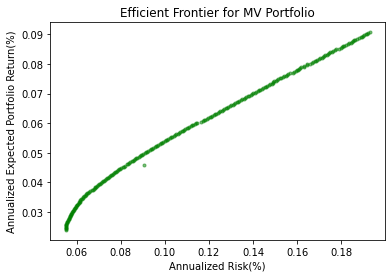

In [131]:
#Graph Efficient Frontier
import matplotlib.pyplot as plt

NoPoints = riskPoint.size

colours = "green"
area = np.pi*3

plt.title('Efficient Frontier for MV Portfolio')
plt.xlabel('Annualized Risk(%)')
plt.ylabel('Annualized Expected Portfolio Return(%)' )
plt.scatter(riskPoint, retPoint, s=area, c=colours, alpha =0.5)
plt.show()

# Naive Portfolio

In [132]:
naive_risks = []
naive_returns = []

for x in np.arange(0, 1, 0.01):
  weights = [x, 1-x]
  risk = np.matmul((np.matmul(weights,cov)),np.transpose(weights)) * trading_days_in_year
  naive_risks.append(np.sqrt(risk))

  #obtain expected portfolio annualized return for the 
  #efficient set portfolios, for trading days = 251
  ret = trading_days_in_year*(np.matmul(weights,r))
  naive_returns.append(ret)

#display efficient set portfolio parameters
# print("Size of the  efficient set:", xOptimalArray.shape )
# print("Optimal weights of the efficient set portfolios: \n", xOptimalArray)
print("Annualized Risk and Return of the efficient set portfolios: \n", \
                                                np.c_[naive_risks, naive_returns])

Annualized Risk and Return of the efficient set portfolios: 
 [[0.06810772 0.00939684]
 [0.06679558 0.0102117 ]
 [0.06553492 0.01102656]
 [0.06432878 0.01184142]
 [0.06318029 0.01265629]
 [0.06209263 0.01347115]
 [0.06106907 0.01428601]
 [0.06011286 0.01510087]
 [0.05922729 0.01591574]
 [0.05841555 0.0167306 ]
 [0.05768077 0.01754546]
 [0.05702592 0.01836032]
 [0.05645379 0.01917519]
 [0.0559669  0.01999005]
 [0.0555675  0.02080491]
 [0.0552575  0.02161978]
 [0.05503839 0.02243464]
 [0.05491126 0.0232495 ]
 [0.05487677 0.02406436]
 [0.05493507 0.02487923]
 [0.05508588 0.02569409]
 [0.05532844 0.02650895]
 [0.05566154 0.02732381]
 [0.05608358 0.02813868]
 [0.05659257 0.02895354]
 [0.05718619 0.0297684 ]
 [0.05786182 0.03058326]
 [0.05861664 0.03139813]
 [0.05944763 0.03221299]
 [0.06035164 0.03302785]
 [0.06132544 0.03384271]
 [0.06236577 0.03465758]
 [0.06346934 0.03547244]
 [0.06463293 0.0362873 ]
 [0.06585336 0.03710216]
 [0.06712751 0.03791703]
 [0.06845239 0.03873189]
 [0.06982512 

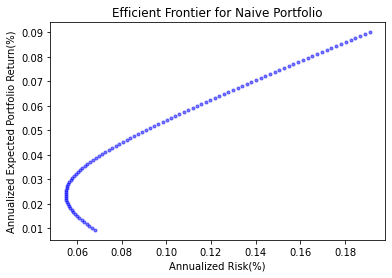

In [133]:
NoPoints = len(naive_risks)

colours = "blue"
area = np.pi*3

plt.title('Efficient Frontier for Naive Portfolio')
plt.xlabel('Annualized Risk(%)')
plt.ylabel('Annualized Expected Portfolio Return(%)' )
plt.scatter(naive_risks, naive_returns, s=area, c=colours, alpha =0.5)
plt.show()

# Combined Graph

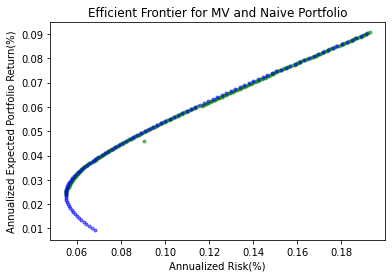

In [134]:
NoPoints = riskPoint.size

colours = "blue"
area = np.pi*3


fig = plt.figure()
ax1 = fig.add_subplot(111)

plt.title('Efficient Frontier for MV and Naive Portfolio')
plt.xlabel('Annualized Risk(%)')
plt.ylabel('Annualized Expected Portfolio Return(%)' )
ax1.scatter(riskPoint, retPoint, s=area, c="green", alpha =0.5)
ax1.scatter(naive_risks, naive_returns, s=area, c="blue", alpha =0.5)
# plt.xlim(riskPoint.min(), riskPoint.max())
plt.show()

In [135]:
cov

,high,low
high,0.000148,-0.000018
low,-0.000018,0.000018


In [136]:
print(high_risk["Close"].var())
print(high_risk["Close"].var() * trading_days_in_year)
print(high_risk["Close"].pct_change().var())
print(high_risk["Close"].pct_change().var() * trading_days_in_year)
print(np.sqrt(high_risk["Close"].pct_change().var() * trading_days_in_year))

9864.007665920406
2485729.9318119423
0.00014831962827593315
0.03737654632553515
0.19333014851681862
